[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture1_fourier_expansion.ipynb)

# Lecture 1: The Fourier Expansion and Orthogonality of Characters

**CS294-92: Analysis of Boolean Functions (Spring 2025)**  
**Instructor: Avishay Tal**  
**Based on lecture notes by: Joyce Lu**  
**Notebook by: Gabriel Taboada**

This notebook follows along with Lecture 1, demonstrating concepts using the `boofun` library.

---

## Course Overview

This course covers the **analysis of Boolean functions**, with applications to:

- **Property Testing** [BLR90]: Testing if functions have certain properties
- **Social Choice**: Arrow's Theorem, KKL Theorem, Friedgut's Junta Theorem
- **Learning Theory** [LMN93]: PAC learning of Boolean functions
- **Cryptography**: Goldreich-Levin Algorithm [GL89]
- **Circuit Complexity** [Håstad88, LMN93]
- **Decision Tree Complexity**: Huang's proof of the Sensitivity Conjecture [Hua19]
- **Quantum Complexity** [BBC+01]

---

## Learning Objectives

1. Understand what a Boolean function is and the {±1} convention
2. Learn the Fourier expansion as a multilinear polynomial
3. Understand orthogonality of characters (parity functions)
4. Apply Parseval's and Plancherel's identities
5. Use the inversion formula to compute Fourier coefficients

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis.fourier import (
    parseval_verify, 
    plancherel_inner_product,
    fourier_degree,
    spectral_norm
)
from boofun.visualization import BooleanFunctionVisualizer, plot_hypercube

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"BooFun version: {bf.__version__}")

BooFun version: 1.1.1


## 1.1 What is a Boolean Function?

A **Boolean function** is a function $f: \{0,1\}^n \to \{0,1\}$.

Boolean functions can model:
- **Pseudorandomness**: A test we want to fool
- **Combinatorics**: Set systems via indicator functions  
- **Social choice**: $n$ votes aggregated into a decision
- **Coding theory**: Error-correcting codes
- **Graph properties**: Properties of graphs encoded in binary

### The {±1} Convention

We typically use $\{+1, -1\}$ instead of $\{0, 1\}$:
- **+1** represents **False** (or 0)
- **-1** represents **True** (or 1)

The isomorphism: $b \mapsto (-1)^b$

This makes the Fourier expansion cleaner (characters become products of variables).

The domain $\{±1\}^n$ is called the **Boolean hypercube**.

The 3-dimensional Boolean hypercube with MAJORITY₃:
  Red vertices: f(x) = 1 (True)
  Blue vertices: f(x) = 0 (False)


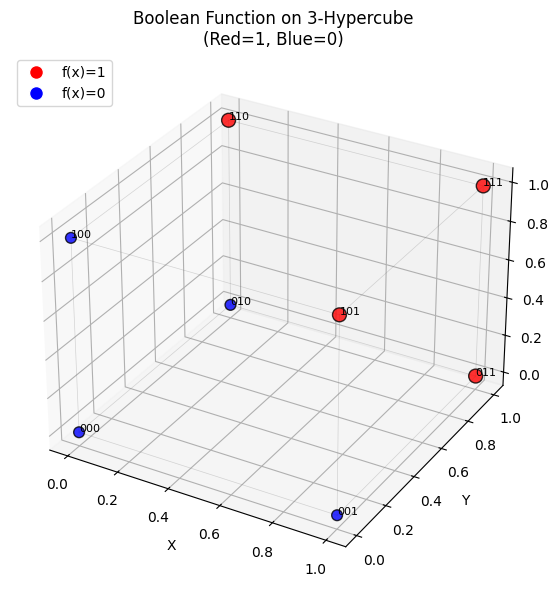

In [3]:
# Visualize the Boolean hypercube (Figure 1.1 from lecture)
maj_3 = bf.majority(3)
print("The 3-dimensional Boolean hypercube with MAJORITY₃:")
print("  Red vertices: f(x) = 1 (True)")
print("  Blue vertices: f(x) = 0 (False)")
_ = plot_hypercube(maj_3, figsize=(8, 6))  # show=True displays the plot

In [4]:
# Creating Boolean functions with boofun

# Example from lecture: max₂(x₁, x₂) = AND(x₁, x₂)
max_2 = bf.AND(2)
print("max₂(x₁, x₂) = AND(x₁, x₂) - outputs maximum of two Booleans")
print("  In {±1}: +1=False, -1=True, so max(-1,-1)=-1, max(+1,+1)=+1")
print()
print("Truth table (in {0,1} notation):")
print("  x₁  x₂  max₂")
for i in range(4):
    x1, x2 = (i >> 0) & 1, (i >> 1) & 1
    print(f"   {x1}   {x2}    {max_2.evaluate(i)}")

# Built-in functions
and_3 = bf.AND(3)
or_3 = bf.OR(3)
maj_3 = bf.majority(3)
parity_3 = bf.parity(3)

print("\nBuilt-in Boolean functions (n=3):")
print(f"  AND(1,1,1) = {and_3.evaluate(7)}")
print(f"  OR(0,0,1) = {or_3.evaluate(1)}")
print(f"  MAJORITY(1,1,0) = {maj_3.evaluate(6)}")
print(f"  PARITY(1,0,1) = {parity_3.evaluate(5)}")

max₂(x₁, x₂) = AND(x₁, x₂) - outputs maximum of two Booleans
  In {±1}: +1=False, -1=True, so max(-1,-1)=-1, max(+1,+1)=+1

Truth table (in {0,1} notation):
  x₁  x₂  max₂
   0   0    False
   1   0    False
   0   1    False
   1   1    True

Built-in Boolean functions (n=3):
  AND(1,1,1) = True
  OR(0,0,1) = True
  MAJORITY(1,1,0) = True
  PARITY(1,0,1) = False


## 1.2 The Fourier Expansion

**Theorem 1.3 (Fundamental Theorem of Boolean Functions):**

Every Boolean function $f: \{\pm 1\}^n \to \mathbb{R}$ can be uniquely represented as a **multilinear polynomial**:

$$f(x) = \sum_{S \subseteq [n]} \hat{f}(S) \cdot \chi_S(x)$$

where:
- $[n] = \{1, \ldots, n\}$
- $\chi_S(x) = \prod_{i \in S} x_i$ is a **character** (parity/Walsh function)
- $\hat{f}(S)$ is the **Fourier coefficient** of $f$ on $S$

### Example 1.1: max₂ (AND function)

$$\text{max}_2(x_1, x_2) = \frac{1}{2} + \frac{1}{2}x_1 + \frac{1}{2}x_2 - \frac{1}{2}x_1 x_2$$

### Example 1.2: MAJORITY₃

$$\text{maj}_3(x_1, x_2, x_3) = \frac{1}{2}x_1 + \frac{1}{2}x_2 + \frac{1}{2}x_3 - \frac{1}{2}x_1 x_2 x_3$$

In [5]:
# Computing Fourier coefficients is simple: just call f.fourier()

# Example 1.1: max₂ = AND₂
max_2 = bf.AND(2)
fourier_max2 = max_2.fourier()

print("Example 1.1: max₂ (AND function)")
print(f"  Fourier coefficients: {fourier_max2}")
print(f"    f̂(∅)   = {fourier_max2[0]:+.2f}  (index 0 = empty set)")
print(f"    f̂({{1}}) = {fourier_max2[1]:+.2f}  (index 1 = {{1}})")
print(f"    f̂({{2}}) = {fourier_max2[2]:+.2f}  (index 2 = {{2}})")
print(f"    f̂({{1,2}}) = {fourier_max2[3]:+.2f}  (index 3 = {{1,2}})")
print("  → max₂(x) = 1/2 + (1/2)x₁ + (1/2)x₂ - (1/2)x₁x₂  ✓")

print()

# Example 1.2: MAJORITY₃  
maj_3 = bf.majority(3)
fourier_maj3 = maj_3.fourier()

print("Example 1.2: MAJORITY₃")
print(f"  Fourier coefficients: {fourier_maj3}")
print("  Non-zero coefficients:")
print(f"    f̂({{1}}) = f̂({{2}}) = f̂({{3}}) = {fourier_maj3[1]:+.2f}")
print(f"    f̂({{1,2,3}}) = {fourier_maj3[7]:+.2f}")
print("  → maj₃(x) = (1/2)x₁ + (1/2)x₂ + (1/2)x₃ - (1/2)x₁x₂x₃  ✓")

Example 1.1: max₂ (AND function)
  Fourier coefficients: [ 0.5  0.5  0.5 -0.5]
    f̂(∅)   = +0.50  (index 0 = empty set)
    f̂({1}) = +0.50  (index 1 = {1})
    f̂({2}) = +0.50  (index 2 = {2})
    f̂({1,2}) = -0.50  (index 3 = {1,2})
  → max₂(x) = 1/2 + (1/2)x₁ + (1/2)x₂ - (1/2)x₁x₂  ✓

Example 1.2: MAJORITY₃
  Fourier coefficients: [ 0.   0.5  0.5  0.   0.5  0.   0.  -0.5]
  Non-zero coefficients:
    f̂({1}) = f̂({2}) = f̂({3}) = +0.50
    f̂({1,2,3}) = -0.50
  → maj₃(x) = (1/2)x₁ + (1/2)x₂ + (1/2)x₃ - (1/2)x₁x₂x₃  ✓


## 1.3 Parseval's Identity

**Corollary 1.7 (Parseval's Identity):** For any $f: \{\pm 1\}^n \to \{\pm 1\}$:

$$\sum_{S \subseteq [n]} \hat{f}(S)^2 = 1$$

This is because $\langle f, f \rangle = \mathbb{E}[f(x)^2] = \mathbb{E}[1] = 1$ when $f$ takes values in $\{\pm 1\}$.

In [6]:
# Parseval's Identity: Σ f̂(S)² = 1 for Boolean functions
# 
# Since f.fourier() returns a NumPy array, we can use numpy operations!

# Built-in functions
maj3 = bf.majority(3)
fourier = maj3.fourier()

# The sum of squared coefficients equals the dot product with itself
print("NumPy-style Parseval verification:")
print(f"  fourier @ fourier = {fourier @ fourier:.6f}")
print(f"  np.sum(fourier**2) = {np.sum(fourier**2):.6f}")
print(f"  np.linalg.norm(fourier)**2 = {np.linalg.norm(fourier)**2:.6f}")
print()

# Build composite functions using Boolean operators: &, |, ^, ~
print("Composite functions (built using Boolean operators):")
f1 = bf.AND(3) ^ bf.parity(3)          # AND XOR PARITY
f2 = bf.majority(3) & ~bf.dictator(3, 0)  # MAJORITY AND (NOT x₁)
f3 = (bf.AND(3) | bf.OR(3)) ^ bf.parity(3)  # More complex

functions = {
    "AND₃": bf.AND(3),
    "OR₃": bf.OR(3),
    "MAJORITY₃": bf.majority(3),
    "PARITY₃": bf.parity(3),
    "AND₃ ⊕ PARITY₃": f1,
    "MAJ₃ ∧ ¬x₁": f2,
}

print(f"\n{'Function':<18} | {'‖f̂‖² = f̂·f̂':<12}")
print("-" * 35)
for name, f in functions.items():
    fourier = f.fourier()
    norm_sq = fourier @ fourier  # NumPy dot product
    print(f"{name:<18} | {norm_sq:.6f} ✓")

NumPy-style Parseval verification:
  fourier @ fourier = 1.000000
  np.sum(fourier**2) = 1.000000
  np.linalg.norm(fourier)**2 = 1.000000

Composite functions (built using Boolean operators):

Function           | ‖f̂‖² = f̂·f̂
-----------------------------------
AND₃               | 1.000000 ✓
OR₃                | 1.000000 ✓
MAJORITY₃          | 1.000000 ✓
PARITY₃            | 1.000000 ✓
AND₃ ⊕ PARITY₃     | 1.000000 ✓
MAJ₃ ∧ ¬x₁         | 1.000000 ✓


## 1.4 Characters and the Inversion Formula

The **characters** $\chi_S(x) = \prod_{i \in S} x_i$ compute parity functions:
- $\chi_\emptyset(x) = 1$ (constant function)
- $\chi_{\{1\}}(x) = x_1$ (dictator on variable 1)
- $\chi_{\{1,2\}}(x) = x_1 x_2$ (parity of variables 1 and 2)

**Lemma 1.5**: The characters form an **orthonormal basis**:
$$\langle \chi_S, \chi_T \rangle = \begin{cases} 1 & \text{if } S = T \\ 0 & \text{otherwise} \end{cases}$$

**Inversion Formula** (how to compute Fourier coefficients):
$$\hat{f}(S) = \langle f, \chi_S \rangle = \mathbb{E}_{x}[f(x) \cdot \chi_S(x)]$$

In [7]:
# Inversion Formula: f̂(S) = ⟨f, χ_S⟩ = E[f·χ_S]
#
# Key insight: χ_S is just a parity function on the bits in S!

maj = bf.majority(3)

# Method 1: Direct array lookup (simplest!)
print("Method 1: Direct Fourier coefficient lookup")
print(f"  f̂({{1}})     = maj.fourier()[1] = {maj.fourier()[1]:+.4f}")
print(f"  f̂({{1,2,3}}) = maj.fourier()[7] = {maj.fourier()[7]:+.4f}")
print()

# Method 2: Plancherel inner product ⟨f, χ_S⟩
print("Method 2: Plancherel inner product ⟨f, χ_S⟩")
chi_1 = bf.dictator(3, 0)  # χ_{1} = x₁
chi_123 = bf.dictator(3, 0) ^ bf.dictator(3, 1) ^ bf.dictator(3, 2)  # χ_{1,2,3}
print(f"  ⟨maj, χ_{{1}}⟩     = {plancherel_inner_product(maj, chi_1):+.4f}")
print(f"  ⟨maj, χ_{{1,2,3}}⟩ = {plancherel_inner_product(maj, chi_123):+.4f}")
print()

# Method 3: Probabilistic view - the random variable interpretation!
# f̂(S) = E[f(x)·χ_S(x)] where x is uniform random
# In ±1 notation: multiplication becomes XOR, and E[g] = ĝ(∅)
print("Method 3: Probabilistic view E[f·χ_S]")
print("  Key insight: (f ^ χ_S).fourier()[0] = E[f·χ_S] = f̂(S)")
print(f"  (maj ^ χ_1).fourier()[0]     = {(maj ^ chi_1).fourier()[0]:+.4f}")
print(f"  (maj ^ χ_123).fourier()[0]   = {(maj ^ chi_123).fourier()[0]:+.4f}")
print()

# Method 4: NumPy dot product of Fourier vectors
print("Method 4: NumPy dot product f̂ · χ̂")
print(f"  maj.fourier() @ chi_1.fourier() = {maj.fourier() @ chi_1.fourier():+.4f}")

print("\n" + "="*55)
print("Bonus: Building and working with characters")
print("="*55 + "\n")

# Dictators ARE single-variable characters!
print("Dictators are characters: χ_{i} = bf.dictator(n, i)")
x0 = bf.dictator(3, 0)
print(f"  dictator(3, 0).fourier() = {x0.fourier()}")
print(f"  → Coefficient 1 at index 1 (= 2⁰) ✓")
print()

# Build any character by XOR-ing dictators!
print("Build χ_S by XOR-ing dictators:")
x1 = bf.dictator(3, 1)
chi_01 = x0 ^ x1  # Parity of x₀, x₁
print(f"  χ_{{0,1}} = dictator(0) ^ dictator(1)")
print(f"  fourier() = {chi_01.fourier()}")
print(f"  → Coefficient 1 at index 3 (= 2⁰ + 2¹) ✓")

Method 1: Direct Fourier coefficient lookup
  f̂({1})     = maj.fourier()[1] = +0.5000
  f̂({1,2,3}) = maj.fourier()[7] = -0.5000

Method 2: Plancherel inner product ⟨f, χ_S⟩
  ⟨maj, χ_{1}⟩     = +0.5000
  ⟨maj, χ_{1,2,3}⟩ = -0.5000

Method 3: Probabilistic view E[f·χ_S]
  Key insight: (f ^ χ_S).fourier()[0] = E[f·χ_S] = f̂(S)
  (maj ^ χ_1).fourier()[0]     = +0.5000
  (maj ^ χ_123).fourier()[0]   = -0.5000

Method 4: NumPy dot product f̂ · χ̂
  maj.fourier() @ chi_1.fourier() = +0.5000

Bonus: Building and working with characters

Dictators are characters: χ_{i} = bf.dictator(n, i)
  dictator(3, 0).fourier() = [0. 1. 0. 0. 0. 0. 0. 0.]
  → Coefficient 1 at index 1 (= 2⁰) ✓

Build χ_S by XOR-ing dictators:
  χ_{0,1} = dictator(0) ^ dictator(1)
  fourier() = [0. 0. 0. 1. 0. 0. 0. 0.]
  → Coefficient 1 at index 3 (= 2⁰ + 2¹) ✓


## 1.5 Plancherel's Identity

**Corollary 1.6 (Plancherel's Identity):** For any $f, g: \{\pm 1\}^n \to \mathbb{R}$:

$$\langle f, g \rangle = \sum_{S \subseteq [n]} \hat{f}(S) \hat{g}(S)$$

The inner product in the "time domain" equals the inner product in the "frequency domain".

In [8]:
# Plancherel's Identity: ⟨f, g⟩ = Σ f̂(S)·ĝ(S)
#
# The "time domain" inner product (averaging over inputs) equals
# the "frequency domain" inner product (summing Fourier products).

f = bf.AND(3)
g = bf.OR(3)

print("Plancherel's Identity: ⟨f, g⟩ = Σ f̂(S)·ĝ(S)")
print("=" * 50)
print()

# Three ways to compute the inner product:

# 1. Library function: plancherel_inner_product(f, g)
#    Computes ⟨f, g⟩ = E[f·g] using the Fourier representation
ip1 = plancherel_inner_product(f, g)
print("Method 1: plancherel_inner_product(f, g)")
print(f"  ⟨AND, OR⟩ = {ip1:.4f}")
print()

# 2. NumPy dot product of Fourier vectors (frequency domain)
ip2 = f.fourier() @ g.fourier()
print("Method 2: f.fourier() @ g.fourier()")
print(f"  Σ f̂(S)·ĝ(S) = {ip2:.4f}")
print()

# 3. XOR trick: (f ^ g).fourier()[0] = E[f·g] (probabilistic view!)
#    Because XOR = multiplication in ±1, and f̂(∅) = E[f]
ip3 = (f ^ g).fourier()[0]
print("Method 3: (f ^ g).fourier()[0]  (probabilistic!)")
print(f"  E[f·g] = {ip3:.4f}")
print()

print("All three methods agree! ✓")
print()
print("Interpretation: ⟨AND, OR⟩ = -0.5 means they're anti-correlated")
print("  (they tend to disagree - AND is strict, OR is lenient)")

Plancherel's Identity: ⟨f, g⟩ = Σ f̂(S)·ĝ(S)

Method 1: plancherel_inner_product(f, g)
  ⟨AND, OR⟩ = -0.5000

Method 2: f.fourier() @ g.fourier()
  Σ f̂(S)·ĝ(S) = -0.5000

Method 3: (f ^ g).fourier()[0]  (probabilistic!)
  E[f·g] = -0.5000

All three methods agree! ✓

Interpretation: ⟨AND, OR⟩ = -0.5 means they're anti-correlated
  (they tend to disagree - AND is strict, OR is lenient)


## 1.6 Influences and Spectral Properties

### What is Influence?

The **influence** of variable $i$ measures how often flipping that single bit changes the output:

$$\text{Inf}_i[f] = \Pr_x[f(x) \neq f(x^{\oplus i})]$$

where $x^{\oplus i}$ means "flip the $i$-th bit of $x$".

**Intuition**: In a voting system, $\text{Inf}_i[f]$ is the probability that voter $i$ is *pivotal* - their vote decides the election.

### The Fourier Formula for Influence

From Fourier analysis (O'Donnell, Proposition 2.12):

$$\text{Inf}_i[f] = \sum_{S \ni i} \hat{f}(S)^2$$

The influence equals the sum of squared Fourier coefficients on sets *containing* $i$.

**Intuition**: If $f$ depends on variable $i$ through many high-degree interactions, then $i$ has high influence.

### Total Influence

$$I[f] = \sum_i \text{Inf}_i[f] = \sum_S |S| \cdot \hat{f}(S)^2$$

This equals the **expected number of pivotal coordinates** when $x$ is uniform random.

Also known as *average sensitivity* - measures how sensitive $f$ is to random bit flips.

In [9]:
# Influence: measuring how pivotal each variable is
f = bf.majority(5)
n = 5

print("Influence of MAJORITY₅")
print("=" * 55)
print()

# Show the probabilistic definition by counting pivotal inputs
print("Probabilistic view: Inf_i[f] = Pr[f(x) ≠ f(x^⊕i)]")
print("-" * 55)
for i in range(n):
    pivotal = sum(1 for x in range(2**n) 
                  if f.evaluate(x) != f.evaluate(x ^ (1 << i)))
    print(f"  Variable {i+1}: pivotal in {pivotal}/{2**n} inputs = {pivotal/2**n:.4f}")
print()

# The library computes this via the Fourier formula
print("Fourier formula: Inf_i[f] = Σ_{S∋i} f̂(S)²")
print("-" * 55)
influences = f.influences()
for i, inf in enumerate(influences):
    print(f"  Inf_{i+1}[f] = {inf:.4f}")
print()

# Total influence
total_inf = f.total_influence()
print(f"Total influence I[f] = {total_inf:.4f}")
print(f"  → Expected number of pivotal coordinates per input")
print()

# Compare to other functions
print("Comparison across functions:")
print("-" * 55)
for name, func in [("MAJORITY₅", bf.majority(5)), 
                   ("PARITY₅", bf.parity(5)),
                   ("AND₅", bf.AND(5)),
                   ("DICTATOR", bf.dictator(5, 0))]:
    I = func.total_influence()
    print(f"  I[{name:<10}] = {I:.4f}")

Influence of MAJORITY₅

Probabilistic view: Inf_i[f] = Pr[f(x) ≠ f(x^⊕i)]
-------------------------------------------------------
  Variable 1: pivotal in 12/32 inputs = 0.3750
  Variable 2: pivotal in 12/32 inputs = 0.3750
  Variable 3: pivotal in 12/32 inputs = 0.3750
  Variable 4: pivotal in 12/32 inputs = 0.3750
  Variable 5: pivotal in 12/32 inputs = 0.3750

Fourier formula: Inf_i[f] = Σ_{S∋i} f̂(S)²
-------------------------------------------------------
  Inf_1[f] = 0.3750
  Inf_2[f] = 0.3750
  Inf_3[f] = 0.3750
  Inf_4[f] = 0.3750
  Inf_5[f] = 0.3750

Total influence I[f] = 1.8750
  → Expected number of pivotal coordinates per input

Comparison across functions:
-------------------------------------------------------
  I[MAJORITY₅ ] = 1.8750
  I[PARITY₅   ] = 5.0000
  I[AND₅      ] = 0.3125
  I[DICTATOR  ] = 1.0000


In [10]:
# More spectral analysis features

f = bf.majority(5)

# Find "heavy" Fourier coefficients (significant ones)
print("Heavy coefficients: f.heavy_coefficients(tau=0.1)")
heavy = f.heavy_coefficients(tau=0.1)
print(f"  Coefficients with |f̂(S)| ≥ 0.1:")
for subset, coeff in heavy[:5]:  # Show top 5
    print(f"    S={subset}: f̂(S) = {coeff:+.4f}")
print()

# Spectral weight by degree: where is the "mass" of f?
print("Spectral weight by degree: f.spectral_weight_by_degree()")
weights = f.spectral_weight_by_degree()
for k, w in sorted(weights.items()):
    if w > 0.001:
        print(f"  W^{{={k}}}[f] = {w:.4f}  ({w*100:.1f}% of spectral mass)")

print("\n→ MAJORITY₅ has 70% weight on degree-1 terms (low-degree concentration)")

Heavy coefficients: f.heavy_coefficients(tau=0.1)
  Coefficients with |f̂(S)| ≥ 0.1:
    S=(0,): f̂(S) = +0.3750
    S=(1,): f̂(S) = +0.3750
    S=(2,): f̂(S) = +0.3750
    S=(3,): f̂(S) = +0.3750
    S=(4,): f̂(S) = +0.3750

Spectral weight by degree: f.spectral_weight_by_degree()
  W^{=1}[f] = 0.7031  (70.3% of spectral mass)
  W^{=3}[f] = 0.1562  (15.6% of spectral mass)
  W^{=5}[f] = 0.1406  (14.1% of spectral mass)

→ MAJORITY₅ has 70% weight on degree-1 terms (low-degree concentration)


## 1.7 Visualization

The `boofun` library includes visualization tools for exploring Boolean functions.

### Influence Visualization

A bar chart of influences shows which variables "matter most" to a function.

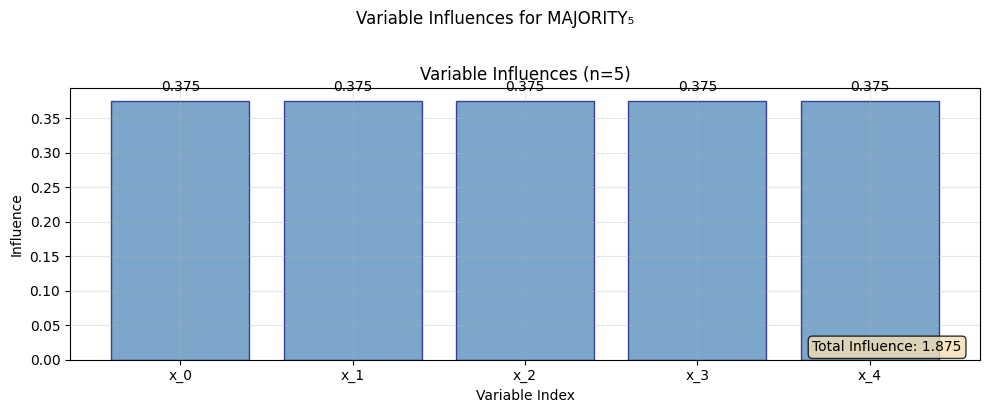

Observation: MAJORITY₅ has equal influence for all variables
  → This is a symmetric function (all variables play the same role)


In [11]:
# Influence visualization
maj5 = bf.majority(5)
viz = BooleanFunctionVisualizer(maj5)

# Plot influence of each variable
fig = viz.plot_influences(figsize=(10, 4), show=False)
plt.suptitle("Variable Influences for MAJORITY₅", y=1.02)
plt.tight_layout()
plt.show()

print("Observation: MAJORITY₅ has equal influence for all variables")
print("  → This is a symmetric function (all variables play the same role)")

### Fourier Spectrum

The **Fourier spectrum** shows how the function's "energy" is distributed across different degrees.

- **Degree 0**: Constant term (the mean of $f$)
- **Degree 1**: Linear terms (individual variable effects)
- **Higher degrees**: Interaction terms (combinations of variables)

**Why it matters**: Functions with weight concentrated at low degrees are "simple" in a precise sense - they're easier to learn, test, and approximate. (More in Lectures 3-4)

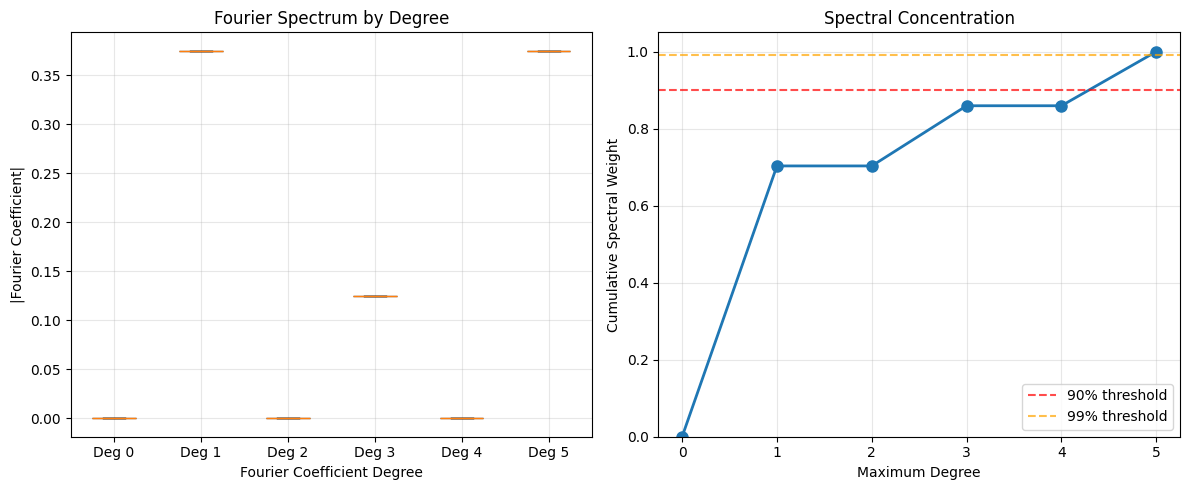

Observation: MAJORITY₅ has 70% of spectral weight on degree-1 terms
  → It's a 'low-degree' function (mostly linear with small corrections)


In [12]:
# Fourier spectrum visualization
fig = viz.plot_fourier_spectrum(figsize=(12, 5), show=False)
plt.tight_layout()
plt.show()

print("Observation: MAJORITY₅ has 70% of spectral weight on degree-1 terms")
print("  → It's a 'low-degree' function (mostly linear with small corrections)")

### Analysis Dashboard

The library provides a comprehensive dashboard showing multiple properties at once.

**Preview of concepts** (covered in later lectures):
- **Noise stability**: How robust is $f$ to random bit flips? (Lecture 5)
- **Noise sensitivity**: $1 - \text{Stab}_\rho[f]$ - probability output changes under noise

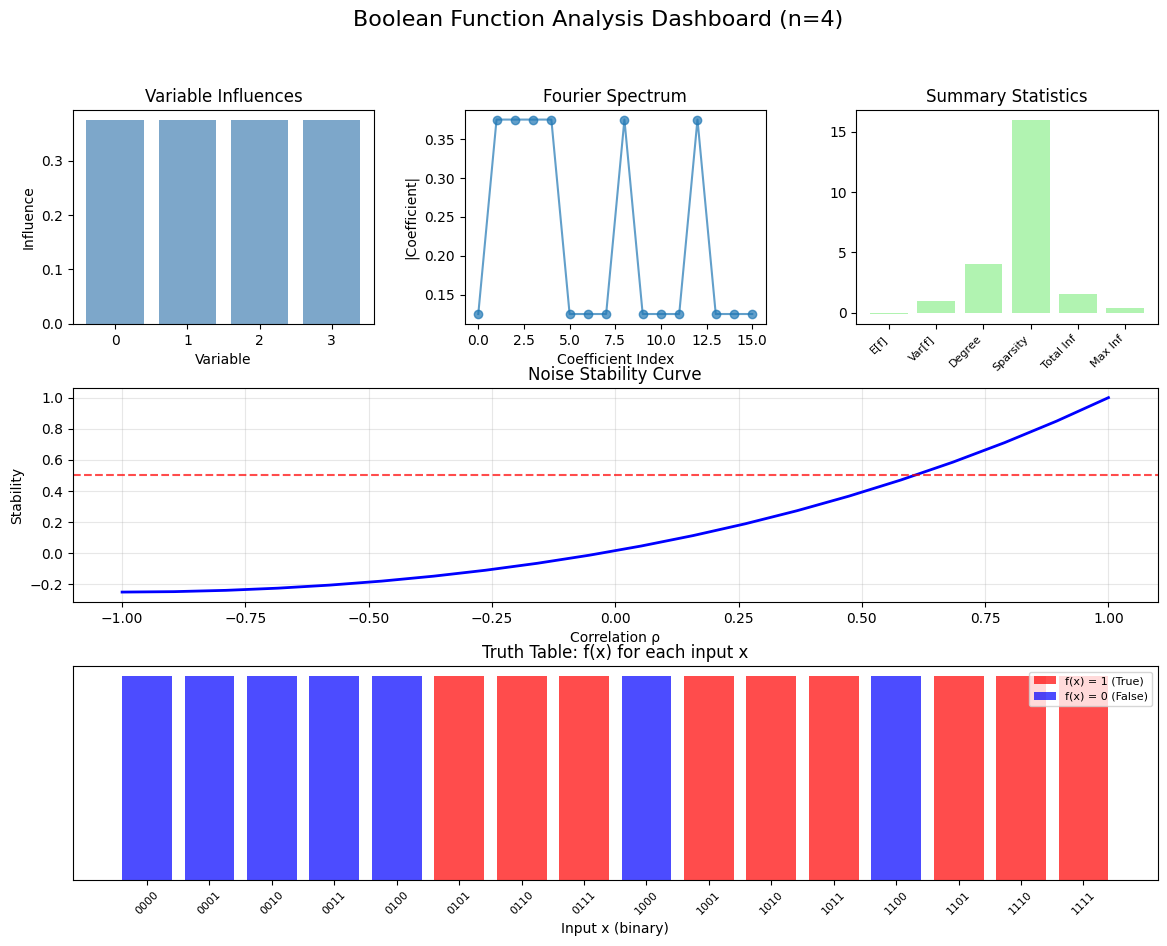

TRIBES function: OR of 4 groups, each an AND of 2 variables
  → Used in the famous KKL theorem (Lecture 6)


In [13]:
# Comprehensive analysis dashboard
tribes = bf.tribes(2, 4)  # Tribes function: OR of ANDs
viz_tribes = BooleanFunctionVisualizer(tribes)

# Create dashboard with extra spacing
fig = viz_tribes.create_dashboard(show=False)
fig.set_size_inches(14, 10)  # Larger figure
plt.tight_layout(pad=2.0)    # More padding between subplots
plt.show()

print("TRIBES function: OR of 4 groups, each an AND of 2 variables")
print("  → Used in the famous KKL theorem (Lecture 6)")

## Summary

### Key Concepts from Lecture 1

| Concept | Formula | Meaning |
|---------|---------|---------|
| **Fourier expansion** | $f(x) = \sum_S \hat{f}(S) \chi_S(x)$ | Every Boolean function is a multilinear polynomial |
| **Characters** | $\chi_S(x) = \prod_{i \in S} x_i$ | Orthonormal basis for function space |
| **Inversion** | $\hat{f}(S) = \mathbb{E}[f \cdot \chi_S]$ | Fourier coefficients as expectations |
| **Parseval** | $\sum_S \hat{f}(S)^2 = 1$ | "Energy" is conserved |
| **Plancherel** | $\langle f, g \rangle = \sum_S \hat{f}(S)\hat{g}(S)$ | Inner products work in both domains |
| **Influence** | $\text{Inf}_i[f] = \Pr[f(x) \neq f(x^{\oplus i})]$ | How pivotal is variable $i$? |

### What We Learned with `boofun`

```python
f.fourier()              # Get all Fourier coefficients (NumPy array)
f.influences()           # Per-variable influences
f.total_influence()      # Sum of all influences
plancherel_inner_product(f, g)  # ⟨f, g⟩ via Fourier
(f ^ g).fourier()[0]     # E[f·g] via the XOR trick
```

### Coming Up Next

| Lecture | Topic | Key Question |
|---------|-------|--------------|
| 2 | **Property Testing** | Is $f$ close to linear? (BLR test) |
| 3-4 | **Learning** | Can we find $f$'s heavy coefficients? |
| 5 | **Noise Stability** | How robust is $f$ to random errors? |
| 6 | **KKL Theorem** | Why do voting systems have pivotal voters? |

---

*Based on lecture notes by Joyce Lu. Notebook created by Gabriel Taboada using the `boofun` library.*